## Import Libraries

In [1]:
from quspin.operators import hamiltonian
from quspin.basis import spinless_fermion_basis_1d
import numpy as np
import matplotlib.pyplot as plt
import itertools
from quspin.tools.evolution import expm_multiply_parallel
from quspin.operators import quantum_LinearOperator
from quspin.operators import quantum_operator
plt.rcParams['figure.figsize'] = [10, 8]

## Define Constants/Helpers

In [2]:
N_group = 4
N = 4
N_filled = N // 2
P_neg1 = 1
t = -0.5
g = 0#1e-3
g_corrected = g / (4 * np.pi ** 2) * N_group ** 2
m = 0.8
PBC = True

In [3]:
def stringbox(lst, caption):
    return caption + "-" * (100 - len(caption))+"\n" + str(lst) + "\n" + "-" * 100

## Fermion Basis

Static couplings:-----------------------------------------------------------------------------------
[['+-', [[0.5, 0, 1], [0.5, 1, 2], [0.5, 2, 3], [0.5, 3, 0]]], ['+-', [[0.5, 1, 0], [0.5, 2, 1], [0.5, 3, 2], [0.5, 0, 3]]], ['+-', [[0.8, 0, 0], [-0.8, 1, 1], [0.8, 2, 2], [-0.8, 3, 3]]], ['z', [[0, 0]]], ['zz', [[0, 0, 1]]], ['zzz', [[0, 0, 1, 2]]], ['zzzz', [[0, 0, 1, 2, 3]]]]
----------------------------------------------------------------------------------------------------
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


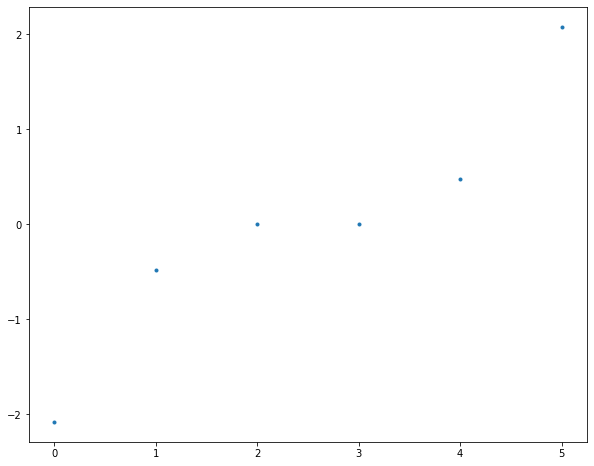

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [4]:
fermion_basis = spinless_fermion_basis_1d(L=N, Nf=N_filled)
fermion_basis_m1 = spinless_fermion_basis_1d(L=N, Nf=N_filled-1)
basis_full = spinless_fermion_basis_1d(L=N)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### TODO: Figure out when antiperiodic BCs apply, why they mess things up
# if PBC and N_filled % 2 == 0:
#     hop_coupling[-1][0] = -hop_coupling[-1][0]
#     hop_coupling_dag[-1][0] = -hop_coupling_dag[-1][0]

### Mass term
mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
E_link_parity = lambda x : -1 if (x % 4) < 2 else 1
for i in range(N):
    E_coupling = [P_neg1 * g * E_link_parity(i) * 2 ** (i+1)] + list(range(i+1))
    static_terms += [["z" * (i+1), [E_coupling]]]

print(stringbox(static_terms, "Static couplings:"))
### Plotting spectrum
H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)
fermion_eigvals = H.eigvalsh()
plt.plot(fermion_eigvals, ".")
plt.show()

### Save a hamiltonian for RTD
H_init = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)

## Real-time Dynamics

In [5]:
### Defining time-evolution hamiltonian
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]

### TODO: Figure out when antiperiodic BCs apply, why they mess things up
# if PBC and N_filled % 2 == 0:
#     hop_coupling[-1][0] = -hop_coupling[-1][0]
#     hop_coupling_dag[-1][0] = -hop_coupling_dag[-1][0]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[-m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
E_link_parity = lambda x : -1 if (x % 4) < 2 else 1
for i in range(N):
    E_coupling = [P_neg1 * g * E_link_parity(i) * 2 ** (i+1)] + list(range(i+1))
    static_terms += [["z" * (i+1), [E_coupling]]]

H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.complex64)

print(static_terms)
# print(H)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
[['+-', [[0.5, 0, 1], [0.5, 1, 2], [0.5, 2, 3], [0.5, 3, 0]]], ['+-', [[0.5, 1, 0], [0.5, 2, 1], [0.5, 3, 2], [0.5, 0, 3]]], ['+-', [[-0.8, 0, 0], [0.8, 1, 1], [-0.8, 2, 2], [0.8, 3, 3]]], ['z', [[0, 0]]], ['zz', [[0, 0, 1]]], ['zzz', [[0, 0, 1, 2]]], ['zzzz', [[0, 0, 1, 2, 3]]]]


In [6]:
E_init,V_init=H_init.eigsh(k=1,which='SA',maxiter=1e8)
psi_i=V_init[:,0]
psi_i = psi_i.reshape((-1,))
del H_init

In [7]:
T = 3
dt = T/30

##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times
Lt = np.zeros(len(times),dtype=dtype_real)              # Lohschmidt echo
# construct piece-wise constant unitaries
expH = expm_multiply_parallel(H.tocsr(),a=-1j*dt,dtype=dtype_cmplx)
# auxiliary array for memory efficiency
psi=psi_i.copy().astype(np.complex128)
work_array=np.zeros((2*len(psi),), dtype=psi.dtype) # twice as long because complex_valued
# prepare output
# file_Loschmidt = open(folder_save+'/Loschmidt_rate',"w")
# file_Loschmidt.close
loschmidt = []
for i in range(len(times)):
    if i % (len(times)//10) == 0:
        print("# T = ",times[i])
    Lt[i]=-np.log(np.abs(np.vdot(psi_i,psi)))/N
#     file_Loschmidtfile = open(folder_save+'/Loschmidt_rate',"a")
    print(f"{times[i]}\t {Lt[i]}")#file_Loschmidtfile.write(f"{times[i]}\t {Lt[i]} \n")
    loschmidt += [Lt[i]]
#     file_Loschmidtfile.close()
    expH.dot(psi,work_array=work_array,overwrite_v=True)
# END of time evolution

# T =  0.0
0.0	 -0.0
0.1	 0.001955797254729506
0.2	 0.007878867699706705
# T =  0.30000000000000004
0.30000000000000004	 0.017942003375528863
0.4	 0.03245339852165077
0.5	 0.051890629752091744
# T =  0.6000000000000001
0.6000000000000001	 0.07695554385604135
0.7000000000000001	 0.10865482544494066
0.8	 0.148394583590778
# T =  0.9
0.9	 0.1979757078766872
1.0	 0.2588313674910662
1.1	 0.32719572248631135
# T =  1.2000000000000002
1.2000000000000002	 0.3762581028186966
1.3	 0.35902586473451764
1.4000000000000001	 0.2950779894326098
# T =  1.5
1.5	 0.2289279684648389
1.6	 0.1734111245279769
1.7000000000000002	 0.12867675555135658
# T =  1.8
1.8	 0.09290558293669746
1.9000000000000001	 0.06446169647133569
2.0	 0.04213669476270868
# T =  2.1
2.1	 0.025078290884953305
2.2	 0.012698065686036899
2.3000000000000003	 0.004603179765043158
# T =  2.4000000000000004
2.4000000000000004	 0.0005520196249913514
2.5	 0.00042810045811695886
2.6	 0.004227905198132254
# T =  2.7
2.7	 0.012060522042463957
2.

Text(0.5, 1.0, 'Non-analycities in Lohscmidt Echo Rate')

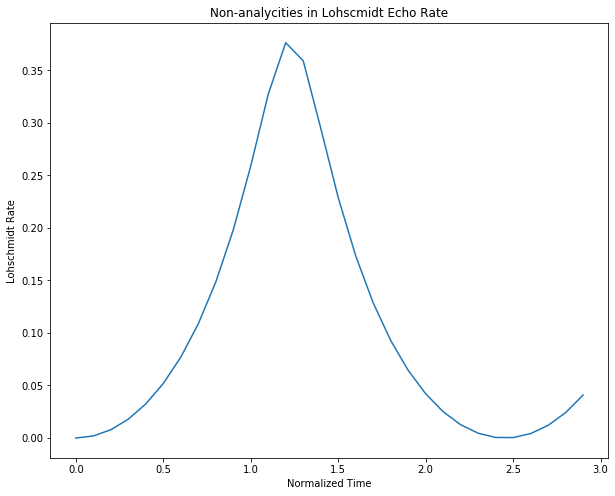

In [8]:
plt.plot(times, loschmidt)
plt.xlabel("Normalized Time")
plt.ylabel("Lohschmidt Rate")
plt.title("Non-analycities in Lohscmidt Echo Rate")

## OTOC Calculations

In [9]:
def c_operator(n):
    cdag_static = [["-",[[1.0,n]]]]
    cdagn = quantum_LinearOperator(cdag_static,basis=basis_full,dtype=np.complex128,check_herm=False,check_pcon=False,check_symm=False)
    return(cdagn)
annihilators = [c_operator(n) for n in range(N)]

In [10]:
##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times

# array to store correlators expectations from psi(t,n) to psi(0,0)
correlators = np.zeros((N,len(times)),dtype=np.complex128)

P_Nhalf = fermion_basis.get_proj(dtype=np.float64)
P_Nhalfminus1 = fermion_basis_m1.get_proj(dtype=np.float64)

H_NHalf_m1 = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis_m1, dtype=np.float64).tocsr()
H_NHalf = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64).tocsr()

for n in range(0, N, 2): #loop over all site pairings
    for i in range(len(times)): #loop over times (for annhilator location)
        # Even Correlators
        leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
        rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

        expmiH = expm_multiply_parallel(H_NHalf_m1,a=1j*dt*i,dtype=dtype_cmplx)
        expiH = expm_multiply_parallel(H_NHalf,a=-1j*dt*i,dtype=dtype_cmplx)

        expiH.dot(leftPsi,overwrite_v=True)
        tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n].dot(P_Nhalf.dot(leftPsi)))
        expmiH.dot(tempLpsi,overwrite_v=True)

        tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[0].dot(P_Nhalf.dot(rightPsi)))

        correlators[n,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>
        
        # Odd Correlators
        leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
        rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

        expiH.dot(leftPsi,overwrite_v=True) 
        tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n+1].dot(P_Nhalf.dot(leftPsi)))
        expmiH.dot(tempLpsi,overwrite_v=True)

        tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[1].dot(P_Nhalf.dot(rightPsi)))

        correlators[n+1,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>
    
correlatorfft = []
for i in range(len(correlators[0, :])):
    fftsum = np.fft.fft(correlators[::2,i]) + np.fft.fft(correlators[1::2,i])
    correlatorfft.append(fftsum)
    
correlatorfft = np.array(correlatorfft)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


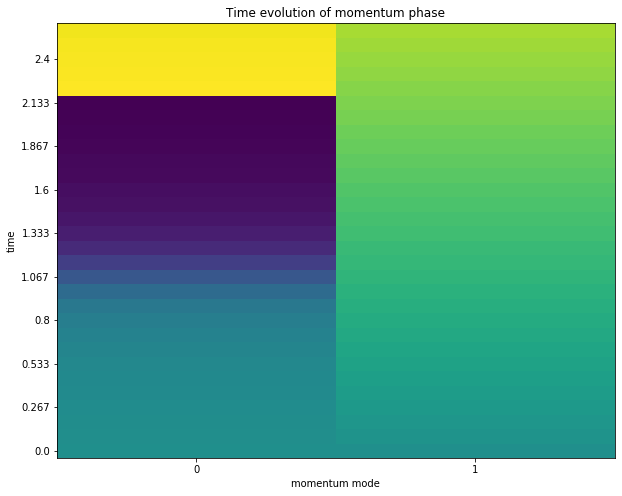

In [11]:
# plt.plot(np.arctan2(np.imag(correlatorfft), np.real(correlatorfft)))
plt.xlabel("momentum mode")
plt.ylabel("time")
plt.title("Time evolution of momentum phase")
step_x = 1 # step between consecutive labels
x_positions = np.arange(0,N//2,step_x) # pixel count at label position
x_labels = np.arange(N//4-N//2+1, N//4+1) # labels you want to see
plt.xticks(x_positions, x_labels)
y_tickcount = 10 # How many labels on y axis
y_positions = np.arange(0,int(T/dt), int((T/dt)/y_tickcount)) # pixel count at label position
y_labels = np.round(np.linspace(0,abs(T*m),y_tickcount), 3) # labels you want to see
plt.yticks(y_positions, y_labels)
plt.imshow(np.angle(correlatorfft), aspect='auto', origin='lower')

## Order Parameter Calculation

In [12]:
t_slices, k_modes = np.shape(correlatorfft)
dphi_k = np.zeros((t_slices-1, k_modes))
dphi_t = np.zeros((t_slices-1, k_modes))
for t in range(t_slices-1):
    for k in range(k_modes):
        dphi_k[t, k] = np.angle(correlatorfft[t, (k+1)%k_modes]/correlatorfft[t, k])
        dphi_t[t, k] = np.angle(correlatorfft[t + 1, k]/correlatorfft[t, k])
        
finite_full = np.zeros((t_slices - 2, k_modes))
for t in range(t_slices-2):
    for k in range(k_modes):
        finite_full[t, k] = (dphi_k[t, k] + dphi_t[t, (k+1)%k_modes]) - (dphi_k[t+1, k] + dphi_t[t, k])
finite_left = np.zeros(t_slices-2)
finite_right = np.zeros(t_slices-2)
for k in range(k_modes//2):
    finite_left += finite_full[:,k]/2/np.pi
    finite_right += finite_full[:,k+k_modes//2]/2/np.pi
n_left = []
n_right = []
for t in range(t_slices-2):
    ntau_left = 0
    ntau_right = 0
    for tau in range(0,t):
        ntau_left += finite_left[tau]
        ntau_right += finite_right[tau]
    n_left.append(ntau_left)
    n_right.append(ntau_right)
n_left = np.array(n_left)
n_right = np.array(n_right)

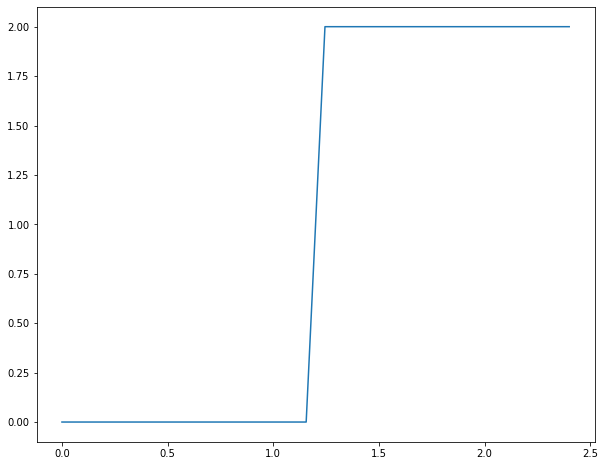

In [13]:
plt.plot(np.linspace(0, T * m, len(n_left)), (n_left-n_right))
plt.show()